<a href="https://colab.research.google.com/github/EduardoP103/AA2_IA/blob/master/AA3_Evaluaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AA3- Implementación de la solución analítica
Integrantes


*   Cabrera Huari, Jesús
*   Manrique Condor, Daniel
*   Pastor Romero, Eduardo
*   Vega Vega, Edseld




## Importaciones realizadas para la preparación de los datos (EDUARDO)


In [ ]:

import sys

!{sys.executable} -m pip install liac-arff

In [ ]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones auxiliares a usar en el proyecto(EDUARDO)

In [ ]:
def load_kdd_dataset(data_path):
    """Lectura del conjunto de datos NSL-KDD."""
    with open(data_path, 'r') as train_set:
        dataset = arff.load(train_set)
    attributes = [attr[0] for attr in dataset["attributes"]]
    return pd.DataFrame(dataset["data"], columns=attributes)

In [ ]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [ ]:
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [ ]:
# Transormador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh,
                                columns=self._columns,
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [ ]:
# Transofrmador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep,
                            columns=self._columns,
                            index=X_copy.index)

## Lectura del conjunto de datos(EDUARDO)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = load_kdd_dataset("/content/drive/MyDrive/NSL-KDD/KDDTrain+.arff")

In [ ]:
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


**Información del tipo de datos ingresados en las columnas** (EDUARDO)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  float64
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  float64
 5   dst_bytes                    125973 non-null  float64
 6   land                         125973 non-null  object 
 7   wrong_fragment               125973 non-null  float64
 8   urgent                       125973 non-null  float64
 9   hot                          125973 non-null  float64
 10  num_failed_logins            125973 non-null  float64
 11  logged_in                    125973 non-null  object 
 12  num_compromised              125973 non-null  float64
 13 

**Etiqueta de la columnas a usar en proyecto**(EDUARDO)

In [ ]:
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

**Histogramas de las variables a usar en el proyecto** (HUGUITO)

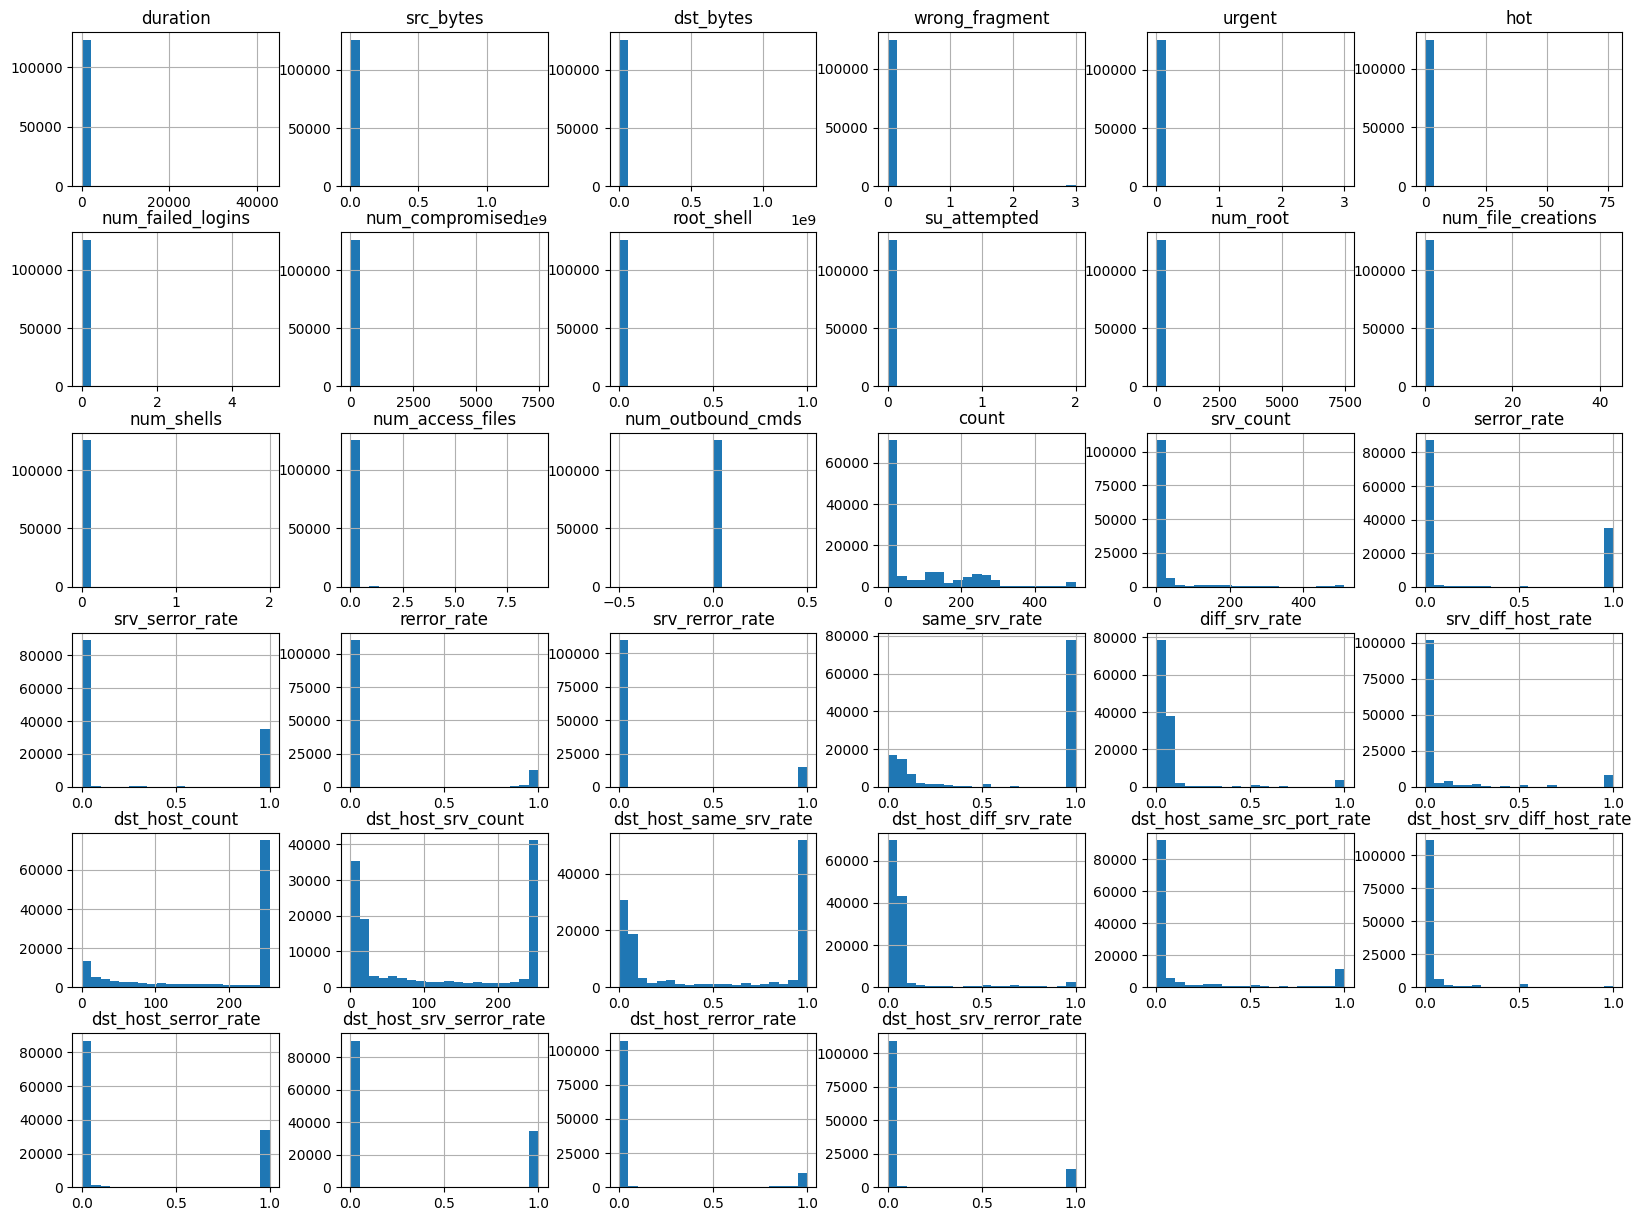

In [ ]:
import matplotlib.pyplot as plt
df.hist(bins=20, figsize=(20,15))
plt.show()

# Diagrama de correlación (HUGUITO)

<ipython-input-69-61295c4f3c17>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


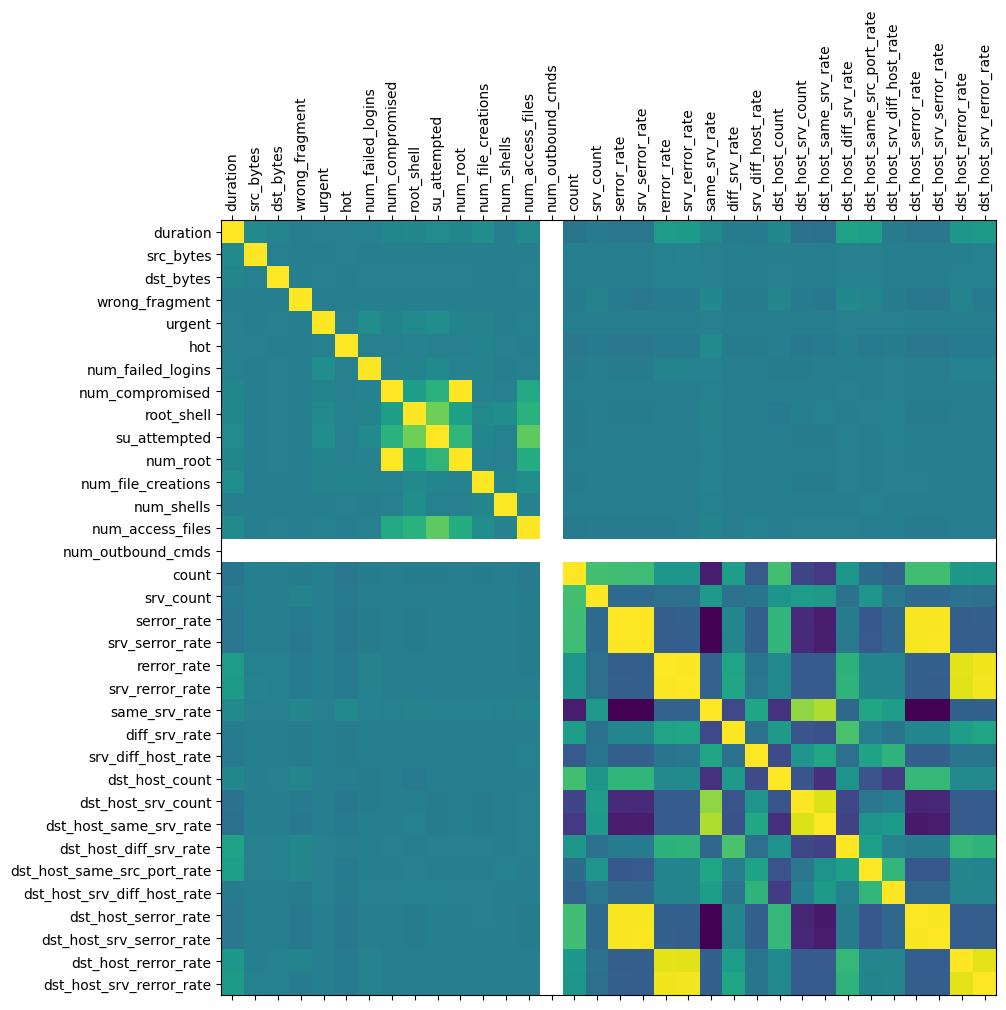

In [ ]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 12))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
plt.yticks(range(len(corr.columns)), corr.columns);

## **`Metodología usada`**

## División del conjunto de datos
 (HUGUITO)
> Bloque con sangría



In [ ]:
# Division del conjunto en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(df)

In [ ]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 75583
Longitud del Validation Set: 25195
Longitud del Test Set: 25195


Para cada uno de los subconjuntos, separamos las etiquetas de las características de entrada.

In [ ]:
# Conjunto de datos general
X_df = df.drop("class", axis=1)
y_df = df["class"].copy()

In [ ]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("class", axis=1)
y_train = train_set["class"].copy()

In [ ]:
# Conjunto de datos de validación
X_val = val_set.drop("class", axis=1)
y_val = val_set["class"].copy()

In [ ]:
# Conjunto de datos de pruebas
X_test = test_set.drop("class", axis=1)
y_test = test_set["class"].copy()

## Preparación del conjunto de datos (HUGUITO)

In [ ]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [ ]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X_df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


DataFramePreparer()

In [ ]:
# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)

In [ ]:
X_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
98320,0.0,icmp,ecr_i,SF,1032.0,0.0,0,0.0,0.0,0.0,...,210.0,65.0,0.31,0.01,0.31,0.00,0.0,0.0,0.0,0.0
8590,0.0,tcp,smtp,SF,1762.0,331.0,0,0.0,0.0,0.0,...,30.0,122.0,0.73,0.07,0.03,0.02,0.0,0.0,0.0,0.0
91385,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,126.0,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0
54349,0.0,tcp,csnet_ns,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,18.0,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
69568,0.0,tcp,smtp,SF,1518.0,342.0,0,0.0,0.0,0.0,...,83.0,125.0,0.66,0.05,0.01,0.02,0.0,0.0,0.0,0.0


In [ ]:
X_train_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
98320,0.0,3.579710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8590,0.0,6.224638,0.641473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
91385,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
54349,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
69568,0.0,5.340580,0.662791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
# Transformamos el subconjunto de datos de validacion
X_val_prep = data_preparer.transform(X_val)

## 1 **Descripción del algoritmo a utilizar** (HUGUITO)

### 1.1 Entrenamiento de un algoritmo de Regresión Logística (HUGUITO)


> La regresión logística es un algoritmo de aprendizaje supervisado utilizado para problemas de clasificación binaria, donde el objetivo es predecir la probabilidad de que una instancia pertenezca a una de las dos clases (0 o 1). A pesar de su nombre, la regresión logística se utiliza para problemas de clasificación y no para problemas de regresión




In [ ]:
# Entrenamos un algoritmo basado en regresión logística
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_prep, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

In [ ]:
y_pred = clf.predict(X_val_prep)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

array([[11414,   460],
       [  248, 13073]])

#Matriz de Confusión - Regresión Logística

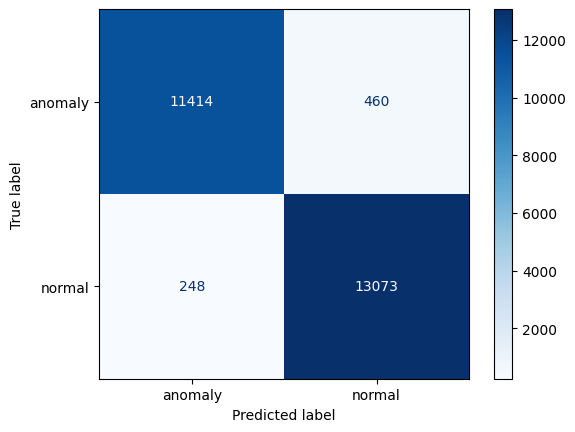

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Supongamos que ya tienes clf, X_val_prep, y_val definidos

# Realiza las predicciones
y_pred = clf.predict(X_val_prep)

# Calcula la matriz de confusión
cm = confusion_matrix(y_val, y_pred)

# Crea la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Muestra la visualización con un formato específico para los valores
disp.plot(cmap=plt.cm.Blues, values_format='3g')

# Muestra la visualización
plt.show()

##2. Entrenamiento por árbol de deciones

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import seaborn as sns
import numpy as np

In [ ]:
tree.fit(X_train_prep, y_train)


AttributeError: ignored

In [ ]:
tree.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=3, random_state=100000)

In [ ]:
# Predecimos sobre nuestro set
pred_y = tree.predict(X_train_prep)


# Comparamos con las etiquetas reales
print('Precision', accuracy_score(pred_y,y_train))

Precision 0.9748356111824087


#Matriz de Confusión - Árbol de desiciones

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_train,pred_y)

NameError: ignored

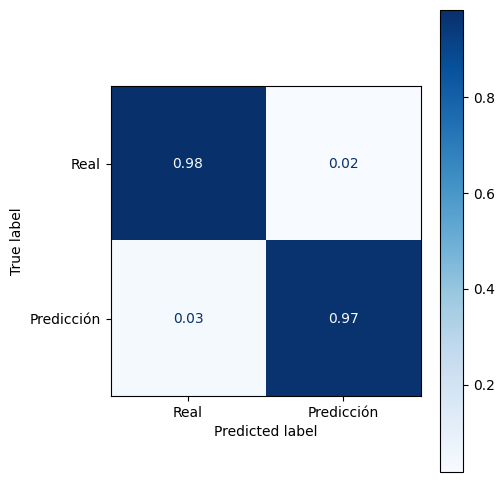

In [ ]:
# creamos un gráfico para la matriz de confusión normalizada
# Normaliza la matriz de confusión
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Supongamos que tienes una lista de etiquetas de clase en el mismo orden que aparecen en la matriz de confusión
labels = ['Real', 'Predicción']  # Reemplaza con tus etiquetas reales

# Crea una instancia de ConfusionMatrixDisplay con las etiquetas y la matriz normalizada
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)

# Plotea la matriz de confusión normalizada
fig, ax = plt.subplots(figsize=(5, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='horizontal', values_format='.2f')

plt.show()

##Procedimiento de toma de desiciones


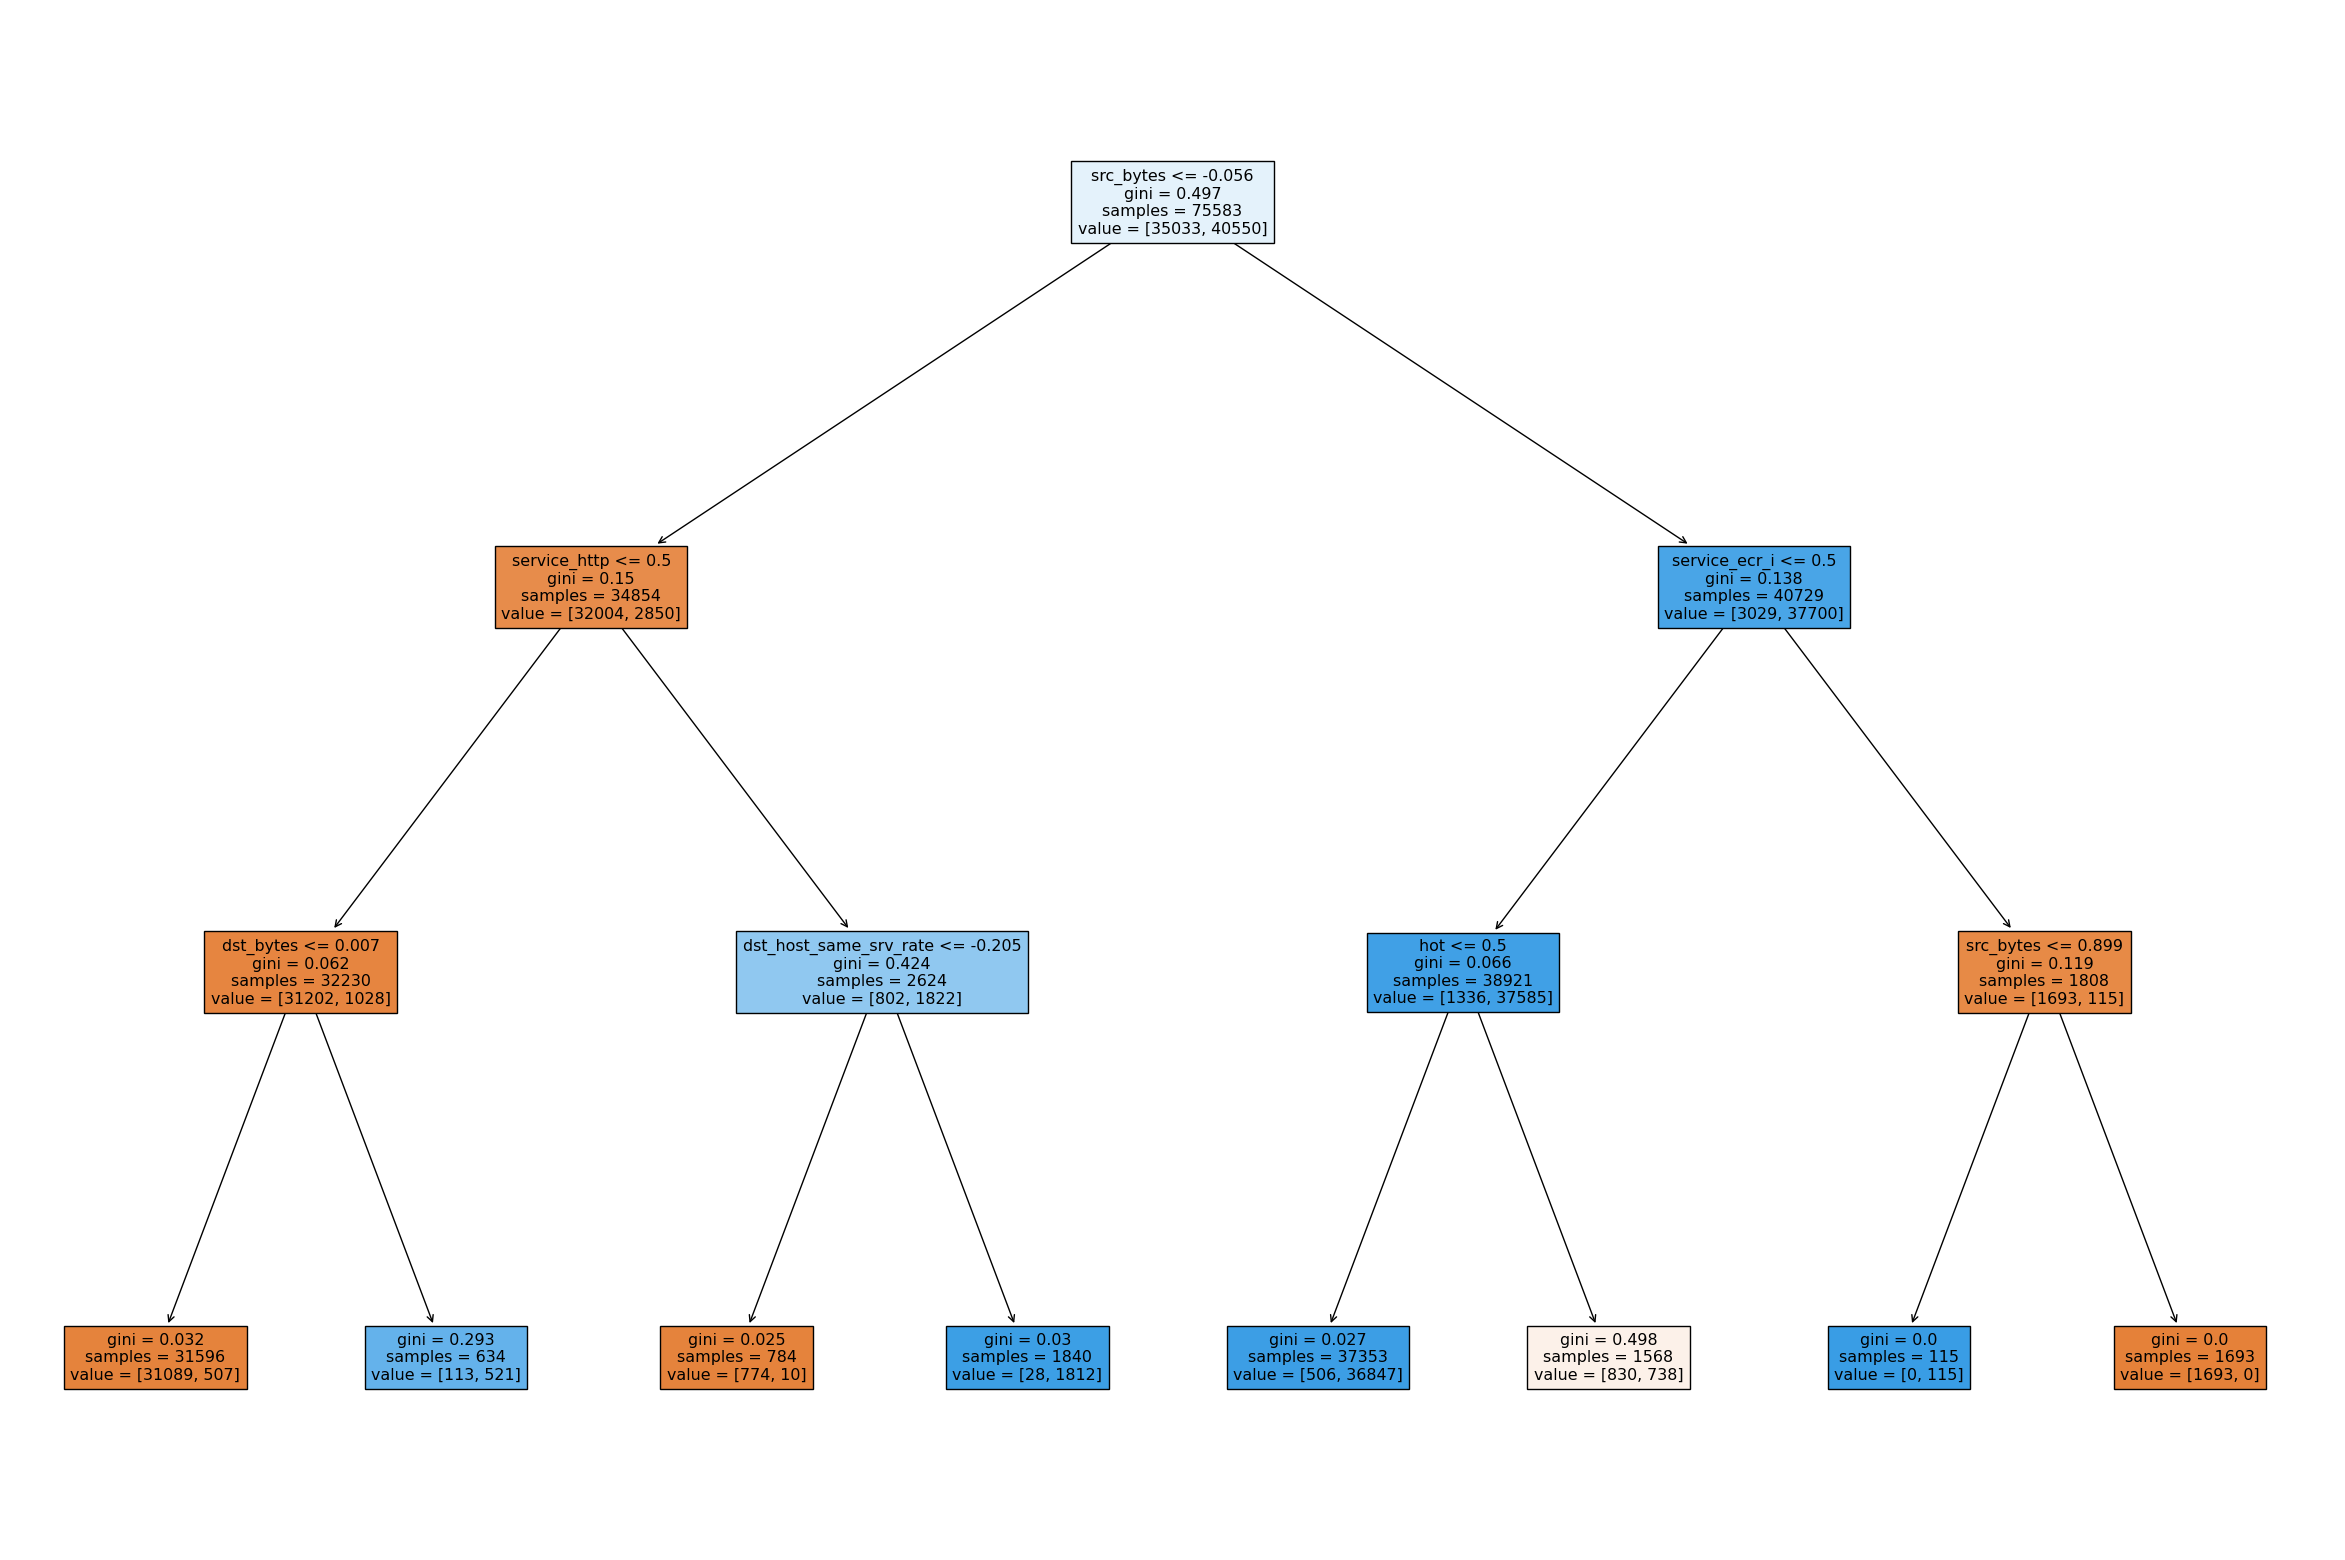

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30, 20))
plot_tree(tree, filled=True, feature_names=X_train_prep.columns)
plt.show()

# **3. Evaluación del modelo**





### Precisión

In [ ]:
from sklearn.metrics import precision_score

print("Precisión:", precision_score(y_val, y_pred, pos_label='anomaly'))

Precisión: 0.9787343508832105


### Recall

In [ ]:
from sklearn.metrics import recall_score

print("Recall:", recall_score(y_val, y_pred, pos_label='anomaly'))

Recall: 0.9612598955701532


### F1 Score

In [ ]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_val, y_pred, pos_label='anomaly'))

F1 score: 0.9699184228416043


**Evaluación  utilizando las Curvas ROC y PR**

### Curva ROC

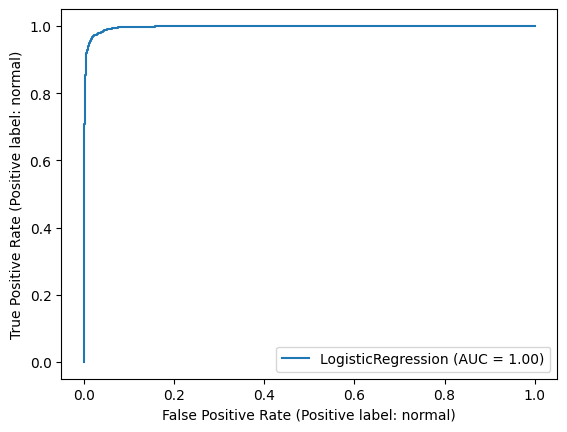

In [ ]:
from sklearn.metrics import RocCurveDisplay

# Calcula las probabilidades de predicción
y_pred_proba = clf.predict_proba(X_val_prep)[:, 1]

# Crea la visualización de la curva ROC
roc_display = RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)

# Ajusta el diseño
plt.show()

### Curva PR

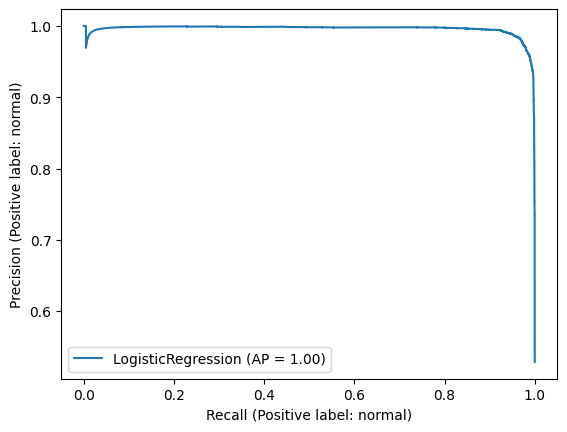

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

# Supongamos que clf, X_val_prep, y_val están definidos

# Calcula las probabilidades de predicción
y_pred_proba = clf.predict_proba(X_val_prep)[:, 1]

# Crea la visualización de la curva Precision-Recall
pr_display = PrecisionRecallDisplay.from_estimator(clf, X_val_prep, y_val)

# Ajusta el diseño
plt.show()

# **Evaluación utilizando la matriz de confusión**

In [ ]:
# Transformamos el subconjunto de datos de validacion
X_test_prep = data_preparer.transform(X_test)

In [ ]:
y_pred = clf.predict(X_test_prep)

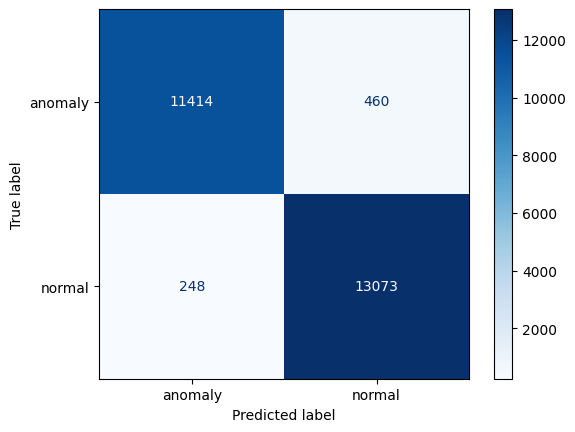

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Realiza las predicciones
y_pred = clf.predict(X_val_prep)

# Calcula la matriz de confusión
cm = confusion_matrix(y_val, y_pred)

# Crea la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Muestra la visualización con un formato específico para los valores
disp.plot(cmap=plt.cm.Blues, values_format='3g')

# Muestra la visualización
plt.show()


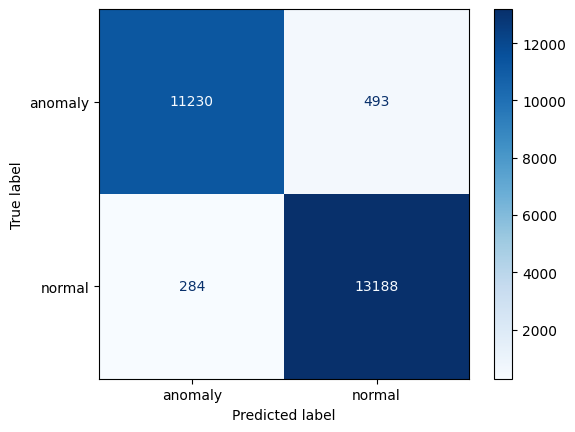

In [ ]:
from sklearn.metrics import confusion_matrix

# Realiza las predicciones en el conjunto de prueba
y_pred = clf.predict(X_test_prep)

# Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crea la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Muestra la visualización con un formato específico para los valores
disp.plot(cmap=plt.cm.Blues, values_format='3g')

# Muestra la matriz de confusión con formato de valores
plt.show()

In [ ]:
print("F1 score:", f1_score(y_test, y_pred, pos_label='anomaly'))

F1 score: 0.9665619486164306
